Thanks for taking your time to complete this take-home task. 

This is where you can show off all your decision science skills through a hands-on project. Together with the dataset, this notebook presents a series of typical problems we face in our job. We expect you to complete the notebook with insightful analysis, elegant code and clear documentation of your findings (perfectly OK to embed within this notebook, just make sure using a distinct color). Please also feel free to keep in the final notebook any code+result where you believe there is value, even if it's not directly addressing the questions below.

We have designed this test with the hope to only take you about 3 hours. We know it’s still quite a commitment of your time and we really appreciate it. That being said, this test is not timed so feel free to spend more time if needed. We’d love to hear your feedback if it actually cost you longer than we intended. It is easy for us to underestimate the required efforts when we know the answers already! Please also tell us if you haven’t had enough fun 😂


## Hints

*   We encourage our decision scientists to use open-source solutions as much as possible instead of re-inventing the wheels. So please feel free to Google for a solution before writing any complicated code. 
*   If you are running short of time but have lots of extra great ideas you'd like to explore, feel free to write down your thoughts in words or pseudo-code instead of code.

## Context

The project we have here is to validate and monitor two credit risk decision models for personal loan underwriting decisions. The information we collected at the underwriting stage of successful applications (i.e. approved and disbursed) were used as the input features of these two models. The two models were trained to predict whether the customers will repay all scheduled payment in the following X months. 

We can split our data into the following three parts:
1.   the **development sample**: all loans applications before 1st August 2019
2.   the **out-of-time monitoring sample**: all loans applications between 1st August 2019 and 1st Jan 2020
3.   the **post-deployment monitoring sample**: all loans applications since 1st Jan 2020


An extended question: assuming that classification power is all we care about, what are the other reasons to not pick the model with highest Gini? It's enough to just write down your thoughts. 


# Part 1. Data processing



## Task 1.1: data cleaning

In [441]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
import warnings

plt.style.use('ggplot')

In [442]:
# Need to run felix_hoschle_data_cleaning.ipynb first to obtain cleaned data sets
mo_df = pd.read_csv("./data/monthly_outcome_cleaned.csv")
ap_df = pd.read_csv("./data/application_cleaned.csv")

## Task 1.2: another target
In order to understand the performance of a model before it's too late, we also want to monitor the repayment behaviours after the first few repayments. 

Could you please create another "early-risk" target *is_bad_3m* which represents whether the customers ever had **2 or more** repayments in arrear at any point of their first three scheduled ones?



In [460]:
# reuse function created when removing Nulls for 12m bad flag
ap_df = add_xmonth_default_flag(ap_df, mo_df, 3, col_suffix='')

# Compare to 12m, there need to be strictly fewer defaults in 3m than in 12m -> Correct
print(ap_df['is_bad_3m'].value_counts())
print(ap_df['is_bad_12m'].value_counts())

is_bad_3m
0.0    57159
1.0      550
Name: count, dtype: int64
is_bad_12m
0.0    55784
1.0     1925
Name: count, dtype: int64


# Part 2. Model validation

In this part let's assume we are still at the model development stage and look at the development sample only (see definition at the start). We will skip the model training part here (which is too much fun to finish in 3 hours), and assume that we already trained two candidate models. These are of course probabilistic classification model, which you can find their scores in ***application.csv*** as columns *model_1* and *model_2*. 

We need to compare their performance and decide which one to use in production. The winner model, once deployed, will be used for decisions of

*   Loan approval: the score must be above certain threshold (which can be adjusted during operation) for the application to be approved. 
*   Loss estimate: for each approved loan, we use the model output to predict the probability of default. 
*   Pricing: based on the loss estimate, we decide the interest rate to be charged in order to cover potential losses. 









## Task 2.1: classification power

A common metric used in the credit risk modelling world is the Gini coefficient, which can be linearly mapped to ROCAUC if that's a term you are more familiar with. Could you please compare the Gini's between the two models as a first step? 




<Axes: xlabel='origination_date'>

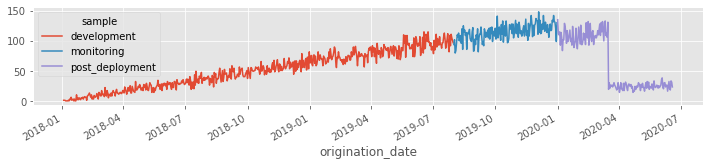

In [461]:
# Split sample into development, monitoring and post deployment
ap_df['sample'] = np.where(ap_df['origination_date'] < pd.to_datetime("2019-08-01"), 'development',
                           np.where(ap_df['origination_date'] < pd.to_datetime("2020-01-01"), 'monitoring', 
                           'post_deployment'))

# Confirm visually that the split worked
ap_df.groupby(['sample', 'origination_date']).size().unstack('sample').plot(figsize=(12,2))

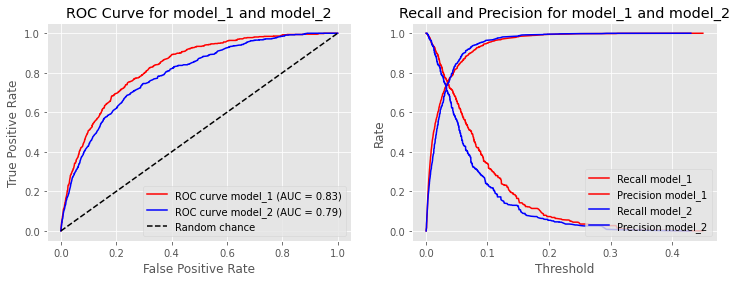

In [485]:
# Results: Model 1 is better than model 2 w.r.t to AUC

def classification_power(df, target, score):
    y_true = df[target]
    y_pred = df[score]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    sample_size = len(y_true)
    bad_rate = round(y_true.mean(),4)
    return auc_score, fpr, tpr, thresholds, sample_size, bad_rate

ap_df_monitoring = ap_df.query('sample=="monitoring"')

auc_score_m1, fpr_m1, tpr_m1, thresholds_m1, _, _ = classification_power(ap_df_monitoring, 'is_bad_12m', 'model_1')
auc_score_m2, fpr_m2, tpr_m2, thresholds_m2, _, _ = classification_power(ap_df_monitoring, 'is_bad_12m', 'model_2')

# put those two in a plt.subplot
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(fpr_m1, tpr_m1, label=f'ROC curve model_1 (AUC = {auc_score_m1:.2f})', color='red')
plt.plot(fpr_m2, tpr_m2, label=f'ROC curve model_2 (AUC = {auc_score_m2:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model_1 and model_2')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds_m1, tpr_m1, label=f'Recall model_1', color='red')
plt.plot(thresholds_m1, 1-fpr_m1, label=f'Precision model_1', color='red')
plt.plot(thresholds_m2, tpr_m2, label=f'Recall model_2', color='blue')
plt.plot(thresholds_m2, 1-fpr_m2, label=f'Precision model_2', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('Recall and Precision for model_1 and model_2')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Task 2.2: classification power in segments

As the population of future business might have different distributions from the development sample, we would ideally want the chosen model to be performant in all segments. For simplicity let's stick with univariate segments only.

Could you please compare the Gini's between the two models in the segments of all the variables? Feel free to define the segments as you see appropriate. 


In [463]:
# There is many ways of splitting the variables
# I restrict myself to exactly 2 groups (1 split) per variable
# I will split the dataset along the median for each variable, this ensures equal n for each group
# We will need to check if there is still a sufficient number of bad loans in each group
# We will continue to use the monitoring sample for the model analysis

relevant_features_for_split = ['loan_term', 'loan_amount',
                              'age_oldest_account', 'total_value_of_mortgage', 
                              'current_utilisation', 'months_since_2_payments_missed', 
                              'number_of_credit_searches_last_3_months']


# loop through each feature and split the data
for feature in relevant_features_for_split:
    ap_df_monitoring[f'{feature}_split'] = np.where(ap_df_monitoring[feature] > ap_df_monitoring[feature].median(), 'high', 'low')


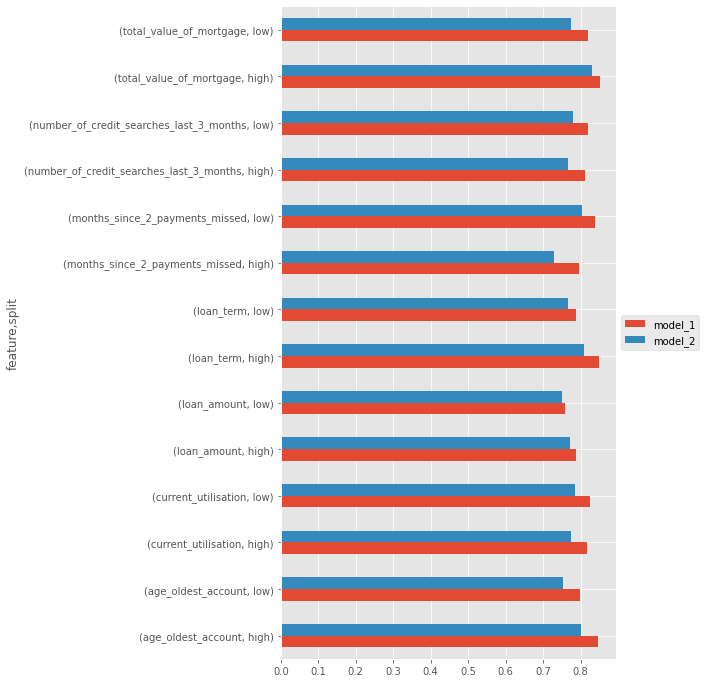

In [464]:
rows = []
for feature in relevant_features_for_split:
    for split in ['high', 'low']:
        for model in ['model_1', 'model_2']:
            auc_score, _, _, _, sample_size, bad_rate = classification_power(ap_df_monitoring.query(f'{feature}_split==@split'), 'is_bad_12m', model)
            rows.append([feature, split, model, auc_score])


# Create a dataframe from the rows
model_performance_segmented = pd.DataFrame(rows, columns=['feature', 'split', 'model', 'auc'])
model_performance_segmented = model_performance_segmented.pivot_table(index=['feature', 'split'], columns='model', values='auc')


# Plot results -> Model 1 performs better in all segments w.r.t to AUC
model_performance_segmented.plot(kind='barh', figsize=(6, 12))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# TODO: Did not check bad rates per segment, it could be that very few failing loans are in some subsamples in which case results might be unreliable


## Task 2.3: accuracy 
As we want to use our model for loss estimates and pricing of each customer, could you please check whether the scores (as probabilistic predictions) are accurate with respect to the actual "bad rates" (i.e. the fraction of *is_bad_12m*=1 among customers of similar scores)


Text(0.5, 1.0, 'Actual bad rate and predicted bad rate per model_1 score decile')

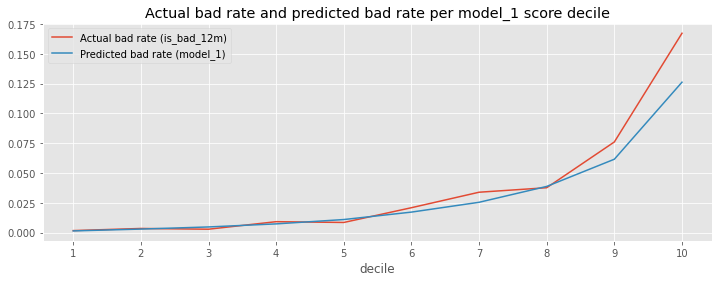

In [465]:
# split ap_df_monitoring into 10 equal portions based on model_1 score
ap_df_monitoring['decile'] = pd.qcut(ap_df_monitoring['model_1'], 10, labels=False) + 1
ap_df_monitoring.groupby('decile').size()
# For each decile and calculate the bad rate based on is_bad_12m and the average model_1 score
bad_rate_per_decile = ap_df_monitoring.groupby('decile').agg({'is_bad_12m':'mean', 'model_1':'mean'})
# plot results as line plot
plt.figure(figsize=(12, 4))
bad_rate_per_decile['is_bad_12m'].plot()
bad_rate_per_decile['model_1'].plot()
plt.legend(['Actual bad rate (is_bad_12m)', 'Predicted bad rate (model_1)'])
t = plt.xticks(range(1, 11))
plt.title('Actual bad rate and predicted bad rate per model_1 score decile')

## Task 2.4: calibration

We also want to monitor the early risk indicator *is_bad_3m* in case something really bad happens (e.g. a pandemic). For that we need to calibrate our scores to the probability of such short-term outcome. Could you please create the calibrated scores for the two models and validate them? (Hint: if this is not a topic you are familiar with, scikit-learn has some handy utilities)

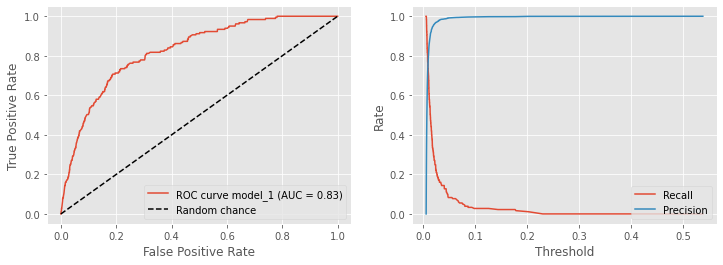

In [489]:
# Not sure if I am doing this right, but I woud just predict is_bad_3m based on the model_1 and model_2 scores

ap_df_development = ap_df.query('sample=="development"')
ap_df_monitoring = ap_df.query('sample=="monitoring"')
ap_df_post_deployment = ap_df.query('sample=="post_deployment"')

# Run logistic regression on model_1 and model_2 with is_bad_3m as target
# Results: Model 1 is better than model 2
X_train = ap_df_development[['model_1', 'model_2']]
y_train = ap_df_development['is_bad_3m']

X_test = ap_df_monitoring[['model_1', 'model_2']]
y_test = ap_df_monitoring['is_bad_3m']

lr = LogisticRegression()
lr.fit(X_train, y_train)

ap_df_monitoring['is_bad_3m_pred'] = lr.predict_proba(X_test)[:, 1]

# RoC curve of new model
auc_score, fpr, tpr, thresholds, _, _ = classification_power(df=ap_df_monitoring, target='is_bad_3m', score='is_bad_3m_pred')


# Plot RoC curve and Recall/Precision
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve model_1 (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, tpr, label=f'Recall')
plt.plot(thresholds, 1-fpr, label=f'Precision')
plt.xlabel('Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Part 3. Model monitoring

The training and validation of a model is just part of the story. A large part of our work is to understand how our models perform in real life deicisioning and how we adapt to the changing market. In this part we will look into the monitoring sample (see definition at the start).

Now let's assume that we have choosen *model_1* and deployed it to production since 1st Jan 2020. On that day, our decision engine started to use that model, and since then only approved applications with *model_1*<0.05. 


## Task 3.1: model performance

How did the model perform in this monitoring sample, before & after its deployment into production? How does that compare to the expectation from the development sample? 

In [467]:
ap_df_development = ap_df.query('sample=="development"')
ap_df_monitoring = ap_df.query('sample=="monitoring"')
ap_df_post_deployment = ap_df.query('sample=="post_deployment"')

auc_score_dev, fpr_dev, tpr_dev, thresholds_dev, _, _ = classification_power(ap_df_development, 'is_bad_12m', 'model_1')
auc_score_mon, fpr_mon, tpr_mon, thresholds_mon, _, _ = classification_power(ap_df_monitoring, 'is_bad_12m', 'model_1')
auc_score_post, fpr_post, tpr_post, thresholds_post, _, _ = classification_power(ap_df_post_deployment, 'is_bad_12m', 'model_1')

# Calculate precision and recall for threshold<0.05
# Do it for development, monitoring and post deployment
threshold = 0.05
ap_df_development['prediction'] = np.where(ap_df_development['model_1'] > threshold, 1, 0)
ap_df_monitoring['prediction'] = np.where(ap_df_monitoring['model_1'] > threshold, 1, 0)
ap_df_post_deployment['prediction'] = np.where(ap_df_post_deployment['model_1'] > threshold, 1, 0)

# Calculate precision and recall for columns is_bad_12m and prediction
precision_dev = ap_df_development.query('prediction==1')['is_bad_12m'].mean()
recall_dev = ap_df_development.query('is_bad_12m==1')['prediction'].mean()
# same for monitoring
precision_mon = ap_df_monitoring.query('prediction==1')['is_bad_12m'].mean()
recall_mon = ap_df_monitoring.query('is_bad_12m==1')['prediction'].mean()
# same for post deployment
precision_post = ap_df_post_deployment.query('prediction==1')['is_bad_12m'].mean()
recall_post = ap_df_post_deployment.query('is_bad_12m==1')['prediction'].mean()
# Create table with results
res = pd.DataFrame({'precision':[precision_dev, precision_mon, precision_post], 
              'recall':[recall_dev, recall_mon, recall_post]}, 
              index=['development', 'monitoring', 'post deployment'])
# pretty print the results
print(res)


                 precision    recall
development       0.122034  0.651184
monitoring        0.121247  0.657188
post deployment   0.083333  0.010309


## Task 3.2: why the changes?

If you observe a difference, what do you think can be the reason(s)? How are you going to verify your hypothesis?

In [468]:
# This is a little bit surprising. The model was trained for the development sample. 
# If classic oversampling was responsible, one would expect that precision/recall would also drop for the monitoring sample.
# This suggests that the patterns in the out of time sample are different from the development AND monitoring sample. 

## Task 3.3: new variable

You might have noticed that a new variable ***stress_score*** has become available since late 2019. Can you figure out whether there is additional classification power from this variable over our models? 

If so, how would you incorporate it into our decision model?


In [469]:
# Confirm NULL values for stress_score
# Results: Not usable for development set, but available for monitoring (37% missing) and post deployment (0% missing   )
print(ap_df.groupby('sample')['stress_score'].apply(lambda x: x.isnull().mean()))
print(ap_df.groupby('sample').size())


sample
development        1.000000
monitoring         0.376737
post_deployment    0.000000
Name: stress_score, dtype: float64
sample
development        29529
monitoring         17556
post_deployment    10624
dtype: int64


Text(0.5, 1.0, 'Post deployment')

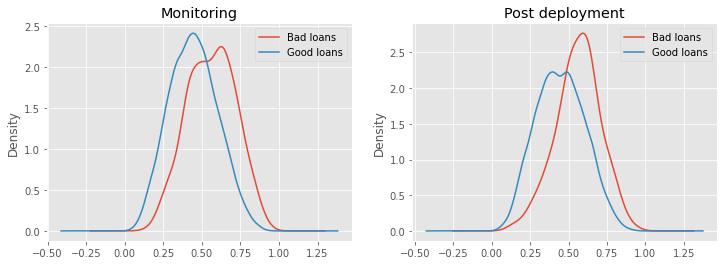

In [470]:
# density function for stress_score split by is_bad_12m
# Results: Stress score is separating good and bad loans somewhat and appears to have predictive power
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

ap_df_monitoring.query('is_bad_12m==1')['stress_score'].plot(kind='kde')
ap_df_monitoring.query('is_bad_12m==0')['stress_score'].plot(kind='kde')
plt.legend(['Bad loans', 'Good loans'])
plt.title('Monitoring')

plt.subplot(1, 2, 2)
ap_df_post_deployment.query('is_bad_12m==1')['stress_score'].plot(kind='kde')
ap_df_post_deployment.query('is_bad_12m==0')['stress_score'].plot(kind='kde')
plt.legend(['Bad loans', 'Good loans'])
plt.title('Post deployment')



In [471]:
# The stress_score variable is somewhat correlated with model_1, however, the correlation is week enough that there still might be predictive power in stress_score
ap_df_monitoring_dropna = ap_df_monitoring.dropna(subset=['stress_score'])
ap_df_post_deployment_dropna = ap_df_post_deployment.dropna(subset=['stress_score'])

# Low, but significant correlation, so we would still expect additional predictive power from stress_score
correlation, p_value = pearsonr(ap_df_monitoring_dropna['stress_score'], ap_df_monitoring_dropna['model_1'])
print(f'Correlation between stress_score and model_1: {correlation:.4f} (p-value: {p_value:.4f})')

# even less of a correlation which would be good for predictive power
correlation, p_value = pearsonr(ap_df_post_deployment_dropna['stress_score'], ap_df_post_deployment_dropna['model_1'])
print(f'Correlation between stress_score and model_1: {correlation:.4f} (p-value: {p_value:.4f})')

Correlation between stress_score and model_1: 0.0454 (p-value: 0.0000)
Correlation between stress_score and model_1: 0.0019 (p-value: 0.8446)


<Axes: >

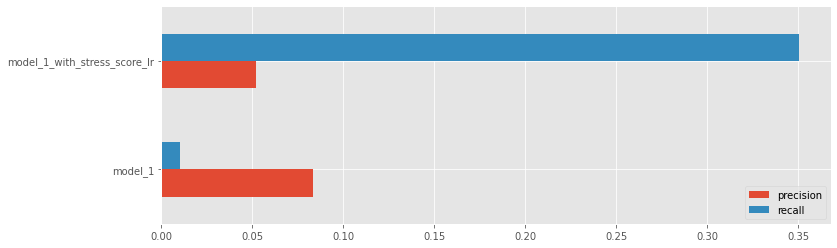

In [529]:
# To prove the predictive power we will fit a logistic regression model with model_1 and stress_score as input variables
# If stress_score is predictive, we would expect the AUC to increase
# We would also expect the precision and recall to increase at the given threshhold
# Other models like Random Forest or Gradient Boosting could be used as well

# Results:
# Adding stress_score as feature in an logistic regression improves AUC slightly and yields a higher RoC curve at most thresholds
# At the predefined threshold, precision is slightly lower for the LR model, but recall is significantly higher


imputer = SimpleImputer(strategy='mean')

X_train = ap_df_monitoring[['model_1', 'stress_score']]
X_train = imputer.fit_transform(X_train)
y_train = ap_df_monitoring['is_bad_12m']

X_test = ap_df_post_deployment[['model_1', 'stress_score']]
X_test = imputer.transform(X_test)
y_test = ap_df_post_deployment['is_bad_12m']


# fit logistic regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# predict
ap_df_post_deployment['model_1_with_stress_score_lr'] = lr.predict_proba(X_test)[:, 1]

# RoC curve for model_1 and model_1_with_stress_score_lr
auc_score_m1s_lr, fpr_m1s_lr, tpr_m1s_lr, thresholds_m1s_lr, _, _ = classification_power(df=ap_df_post_deployment, target='is_bad_12m', score='model_1_with_stress_score_lr')
auc_score_m1, fpr_m1, tpr_m1, thresholds_m1, _, _ = classification_power(df=ap_df_post_deployment, target='is_bad_12m', score='model_1')

# Precision & Recall for model_1 and model_1_with_stress_score_lr @ threshold 0.05
threshold = 0.05
ap_df_post_deployment['prediction_lr'] = np.where(ap_df_post_deployment['model_1_with_stress_score_lr'] > threshold, 1, 0)
ap_df_post_deployment['prediction'] = np.where(ap_df_post_deployment['model_1'] > threshold, 1, 0)

precision_lr = ap_df_post_deployment.query('prediction_lr==1')['is_bad_12m'].mean()
recall_lr = ap_df_post_deployment.query('is_bad_12m==1')['prediction_lr'].mean()

precision = ap_df_post_deployment.query('prediction==1')['is_bad_12m'].mean()
recall = ap_df_post_deployment.query('is_bad_12m==1')['prediction'].mean()

# Create table with results
res = pd.DataFrame({'precision':[precision, precision_lr], 
              'recall':[recall, recall_lr]}, 
              index=['model_1', 'model_1_with_stress_score_lr']).T

# plot
res.T.plot(kind='barh', figsize=(12, 4))
